In [4]:
import pandas as pd
import pycountry
# 这个文件是相关性分析和灵敏度分析

df_gci = pd.read_csv("Cyber_security.csv", usecols=["Country", "GCI"])

# 这个文件应该是由anal_2生成的
df_z = pd.read_csv("merged_with_z.csv", index_col="country_code")


if df_z.index.duplicated().any():
    print("警告：merged_with_z.csv中存在重复的country_code！")
    print("重复的索引值:", df_z.index[df_z.index.duplicated()].tolist())
    df_z = df_z[~df_z.index.duplicated(keep='last')]

def country_to_iso2(name):
    """将国家全名转换为ISO2代码"""
    try:
        special_cases = {
            "South Korea": "KR",
            "North Korea": "KP",
            "Vatican City": "VA",
            "Cote d'ivoire": "CI",
            "Timor-Leste": "TL",
            "Congo": "CG",
            "Taiwan": "TW",
            "Hong Kong": "HK"
        }
        if name in special_cases:
            return special_cases[name]
        country = pycountry.countries.search_fuzzy(name)[0]
        return country.alpha_2
    except:
        return None

df_gci["iso2"] = df_gci["Country"].apply(country_to_iso2)
df_gci = df_gci.dropna(subset=["iso2"]).drop_duplicates(subset="iso2", keep="first")


merged_df = df_z.copy()
merged_df["GCI"] = df_gci.set_index("iso2")["GCI"]
merged_df["F"] = merged_df["Y"] * merged_df["Z"]
# 这里应该有249 行，如果不是，运行anal_2

print("合并后行数:", len(merged_df))
print("缺失GCI值的数量:", merged_df["GCI"].isnull().sum())
merged_df.head()
merged_df.to_csv("merged_data.csv")

合并后行数: 249
缺失GCI值的数量: 63


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt




print("缺失值统计：")
print(merged_df[["GCI", "X", "Y", "Z"]].isnull().sum())

merged_clean = merged_df.fillna(merged_df.quantile(0.25))
merged_clean["F"] = merged_clean["Y"] * merged_clean["Z"]
variables = ["GCI", "X", "Y", "Z"]
df_analysis = merged_clean[variables]

缺失值统计：
GCI    63
X       2
Y       2
Z       0
dtype: int64


In [6]:
correlation_matrix = df_analysis.corr(method="pearson")

def calculate_pvalues(df):
    pvalues = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            if i != j:
                r, p = pearsonr(df.iloc[:, i], df.iloc[:, j])
                pvalues.iloc[i, j] = p
    return pvalues

p_values = calculate_pvalues(df_analysis)

print("皮尔逊相关系数矩阵：")
print(correlation_matrix.round(2))
print("\np值矩阵：")
print(p_values.round(3))

皮尔逊相关系数矩阵：
      GCI     X     Y     Z
GCI  1.00 -0.05  0.37  0.52
X   -0.05  1.00 -0.03  0.05
Y    0.37 -0.03  1.00  0.43
Z    0.52  0.05  0.43  1.00

p值矩阵：
      GCI      X      Y     Z
GCI  0.00  0.440  0.000  0.00
X    0.44  0.000  0.586  0.45
Y    0.00  0.586  0.000  0.00
Z    0.00  0.450  0.000  0.00


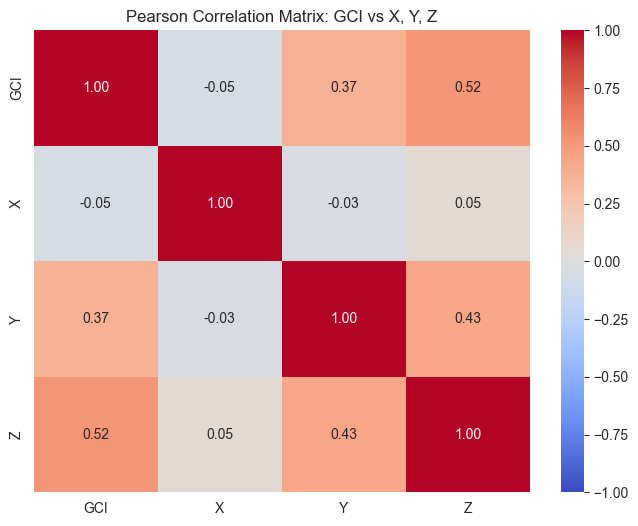

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
 #  mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),  # 隐藏上三角
    fmt=".2f"
)
plt.title("Pearson Correlation Matrix: GCI vs X, Y, Z")
plt.savefig("Pearson_Heat_Map.png", dpi=300, bbox_inches='tight')

plt.show()


In [8]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
import matplotlib.pyplot as plt

# 新增变量 F = Y * Z
merged_clean["F"] = merged_clean["Y"] * merged_clean["Z"]

print("缺失值统计：")
print(merged_df[["GCI", "X", "Y", "Z", "F"]].isnull().sum())



variables = ["GCI", "X", "Y", "Z"]
df_analysis = merged_clean[variables]

缺失值统计：
GCI    63
X       2
Y       2
Z       0
F       2
dtype: int64


In [9]:

def calculate_correlation(df, method="pearson"):
    """计算相关系数矩阵及p值矩阵"""
    corr_matrix = df.corr(method=method)
    p_matrix = pd.DataFrame(np.zeros((len(df.columns), len(df.columns))),
                           columns=df.columns, index=df.columns)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i != j:
                col1 = df.iloc[:, i]
                col2 = df.iloc[:, j]
                if method == "pearson":
                    r, p = pearsonr(col1, col2)
                elif method == "spearman":
                    r, p = spearmanr(col1, col2)
                elif method == "kendall":
                    r, p = kendalltau(col1, col2)
                corr_matrix.iloc[i, j] = r
                p_matrix.iloc[i, j] = p
    return corr_matrix, p_matrix

pearson_corr, pearson_p = calculate_correlation(df_analysis, method="pearson")
print("皮尔逊相关系数矩阵：")
print(pearson_corr.round(2))
spearman_corr, spearman_p = calculate_correlation(df_analysis, method="spearman")
print("\n斯皮尔曼相关系数矩阵：")
print(spearman_corr.round(2))
kendall_corr, kendall_p = calculate_correlation(df_analysis, method="kendall")
print("\n肯德尔相关系数矩阵：")
print(kendall_corr.round(2))

皮尔逊相关系数矩阵：
      GCI     X     Y     Z
GCI  1.00 -0.05  0.37  0.52
X   -0.05  1.00 -0.03  0.05
Y    0.37 -0.03  1.00  0.43
Z    0.52  0.05  0.43  1.00

斯皮尔曼相关系数矩阵：
      GCI     X     Y     Z
GCI  1.00  0.51  0.45  0.49
X    0.51  1.00  0.49  0.81
Y    0.45  0.49  1.00  0.57
Z    0.49  0.81  0.57  1.00

肯德尔相关系数矩阵：
      GCI     X     Y     Z
GCI  1.00  0.39  0.35  0.37
X    0.39  1.00  0.42  0.63
Y    0.35  0.42  1.00  0.47
Z    0.37  0.63  0.47  1.00


In [12]:
#随机移除20%的数据，计算相关系数
import numpy as np
np.random.seed(42)
df_sample = df_analysis.sample(frac=0.9)
# 计算皮尔逊相关系数
pearson_corr_sample, _ = calculate_correlation(df_sample, method="pearson")
print("皮尔逊相关系数矩阵（20%样本）：")
print(pearson_corr_sample.round(2))


皮尔逊相关系数矩阵（20%样本）：
      GCI     X     Y     Z
GCI  1.00 -0.05  0.36  0.51
X   -0.05  1.00 -0.04  0.05
Y    0.36 -0.04  1.00  0.41
Z    0.51  0.05  0.41  1.00


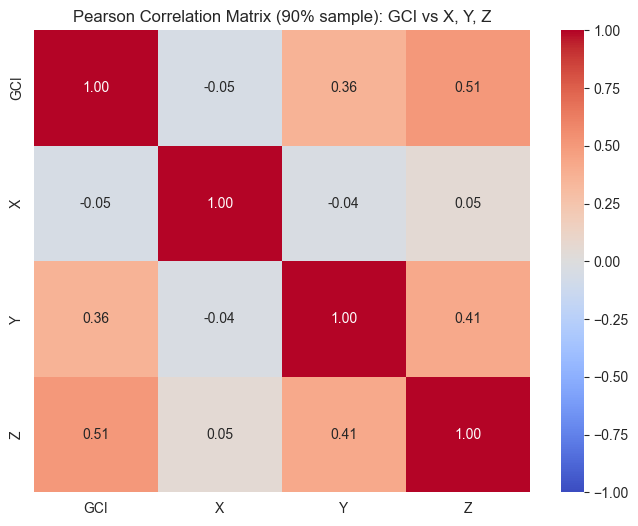

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    pearson_corr_sample,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
 #  mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),  # 隐藏上三角
    fmt=".2f"
)
plt.title("Pearson Correlation Matrix (90% sample): GCI vs X, Y, Z")
plt.savefig("Pearson_Heat_Map_2.png", dpi=300, bbox_inches='tight')

plt.show()
